# Predicting Malaria in Nigeria with Machine Learning

## Spatial Analysis

### Contributors: Brian Liggio, Jessica Sickles, Prashant Toteja, Keely Meyers

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import numpy
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import statsmodels.formula.api as smf
import statsmodels.api as sm


#from gridsearch import get_results
import time
import itertools
from sklearn.linear_model import Ridge
%pylab inline

/Users/Keely/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Keely/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
def feature_to_array(file_n): #Input is raster file with dimensions (n pixels, m pixels) and the output is an array of dimensions (m*n,1) -- Each pixel has a unique identifier
    im = mpimg.imread(file_n)  
    im_greyscale = rgb2gray(im)   
    imarray = numpy.array(im_greyscale)
    feature=[i for a in imarray for i in a]
    return feature

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])   #Greyscale value dimensions

def read_pictures(filename):   #Function to read the images in
    file_name=filename
    im = mpimg.imread(file_name)  
    im_greyscale = rgb2gray(im)

## Reading the Data

In [3]:
file_name = 'Malaria_resistance_sickle_cell.png'
resistance = feature_to_array(file_name) 

file_name ='PfMalaria_fever_porportion_to_all_illness_2015.png'
fever_proportion = feature_to_array(file_name) 

file_name = 'PfPR_2015_NGA_proportion_2_10.png'
mosquito_proportion = feature_to_array(file_name) 

file_name = 'temp_suitability.png'
temp_suitability = feature_to_array(file_name) 

file_name = 'Travel_time_to_urban_centers.png'
proximity_to_urban = feature_to_array(file_name) 

file_name = 'Urban2012.png'
urban = feature_to_array(file_name) 

file_name = 'USE_annual_mean_temp.png'
annual_mean_temp = feature_to_array(file_name) 

file_name = 'USE_cropland.png'
cropland = feature_to_array(file_name)

file_name = 'USE_prec_seasonality_013.png'
precipitation = feature_to_array(file_name)

file_name = 'USE_primary_vegetation.png'
vegetation = feature_to_array(file_name)

file_name = 'USE_temp_annual_range_2015.png'
annual_temp_range = feature_to_array(file_name)

file_name = 'Water_bodies.png'
water_bodies = feature_to_array(file_name)

file_name = 'PF_parasite_endemicity.png'    #Y variable
endemicity = feature_to_array(file_name) 

file_name = 'Land_coverage.png'     #In or outside Nigeria
land_coverage = feature_to_array(file_name) 

RuntimeError: Error setting jump

file_name='Primary Vegetated Areas_2000.png'

im = mpimg.imread(file_name)  
im_greyscale = rgb2gray(im)   
imarray = numpy.array(im_greyscale)
feature=[a for a in imarray]  #iterable one level out
feature

In [4]:
data = pd.DataFrame([resistance, fever_proportion, mosquito_proportion, temp_suitability, proximity_to_urban, urban, annual_mean_temp, cropland, precipitation, vegetation, annual_temp_range, water_bodies, endemicity]).T

data.columns = ['Resistance','Fever_prop','Mosquito_prop', 'Temp_suitability','Proximity_to_urban','Urban','Annual_mean_temp','Cropland','Precipitation', 'Vegetation', 'Annual_temp_range', 'Water_bodies', 'Endemicity']


## Machine Learning - Regressions

In [5]:
## Splitting into X and Y training/testing sets

data = data.dropna()

X = data[['Resistance', 'Fever_prop','Mosquito_prop','Temp_suitability', 'Proximity_to_urban', 'Urban', 'Annual_mean_temp', 'Cropland', 'Precipitation','Vegetation', 'Annual_temp_range', 'Water_bodies']]
Y = data['Endemicity']

X_train, X_test = train_test_split(X, test_size=0.2, random_state=21)
Y_train, Y_test = train_test_split(Y, test_size=0.2, random_state=21)


## Ordinary Least Squares Regression

In [6]:
model = sm.OLS(Y, X, standardize=False).fit()   #fitting OLS to our data
print(model.summary())
data['Predictions_OLS_1'] = model.predict(X)    #using function to visualize it's fit

                            OLS Regression Results                            
Dep. Variable:             Endemicity   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 1.365e+05
Date:                Wed, 13 Mar 2019   Prob (F-statistic):               0.00
Time:                        15:07:23   Log-Likelihood:                 61882.
No. Observations:              120432   AIC:                        -1.237e+05
Df Residuals:                  120420   BIC:                        -1.236e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Resistance             0.8262      0

In [7]:
## Creating training/testing data sets w/ both X & Y

data_train = pd.concat([X_train,Y_train],axis=1)
data_test = pd.concat([X_test,Y_test],axis=1)

In [8]:
## Evaluating Model

ols_mod_train = smf.ols('Endemicity ~ Resistance + Fever_prop + Temp_suitability + Proximity_to_urban + Urban + Annual_mean_temp + Cropland + Precipitation + Mosquito_prop + Vegetation + Annual_temp_range + Water_bodies', data = data_train).fit()
print (roc_auc_score(np.where(ols_mod_train.predict(data_test)>0.5,1,0), data_test['Endemicity']))

0.9801807271247823


In [9]:
print (roc_auc_score(np.where(ols_mod_train.predict(data)>0.5,1,0),data['Endemicity']))

0.9796774085051083


In [10]:
data['Predictions_OLS_1'].head(10) #View of first 10 predictions as per the model

0    0.965435
1    0.965435
2    0.965435
3    0.965435
4    0.965435
5    0.965435
6    0.965435
7    0.965435
8    0.965435
9    0.965435
Name: Predictions_OLS_1, dtype: float64

In [11]:
## Linking array to original position of pixels 

file_name='USE_annual_mean_temp.png'
m=numpy.array(Image.open(file_name)).shape[0]
n=numpy.array(Image.open(file_name)).shape[1]
def indexes(m,n):    
    index_2dim={}
    for M in range(0,m*n):
        index_2dim[M]={'i':int(M)//int(n), 'j':M-((int(M)//int(n))*n)}
    return index_2dim
original_index_dict=indexes(m,n)


In [12]:
matrix = np.zeros((m,n))
for M in data.index:
    i=original_index_dict[M]['i']
    j=original_index_dict[M]['j']
    matrix[i][j]=data.Predictions_OLS_1[M] 
m_l=matrix.tolist()

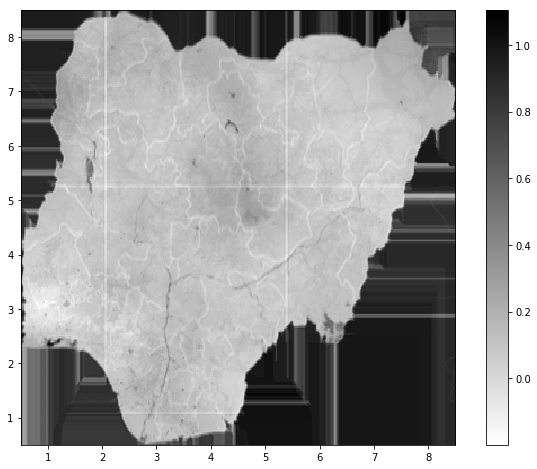

In [13]:
## Creating plot of malaria outbreak 

fig, ax = subplots(figsize=(11, 8))
plt.imshow(m_l,  interpolation='nearest', cmap='binary', extent=(0.5,8.5,0.5,8.5))
plt.colorbar()
plt.savefig('ols.png')

## Random Forest Regressor

In [14]:
from sklearn.ensemble import RandomForestRegressor

In [15]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [16]:
rf.fit(X, Y)

KeyboardInterrupt: 

In [ ]:
rf.score(X,Y)

In [ ]:
rf.feature_importances_

In [ ]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = X.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances


In [ ]:
data['rf_predictions'] = rf.predict(X)

In [ ]:
data['rf_predictions'].head(10)

In [ ]:
errors = abs(predictions - Y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))

In [ ]:
## Calculating mean absolute percentage error (MAPE)

mape = 100 * (errors / Y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), "%")

In [ ]:
## Linking array to original position of pixels 

file_name='USE_annual_mean_temp.png'
m=numpy.array(Image.open(file_name)).shape[0]
n=numpy.array(Image.open(file_name)).shape[1]
def indexes(m,n):    
    index_2dim={}
    for M in range(0,m*n):
        #print(M)
        index_2dim[M]={'i':int(M)//int(n), 'j':M-((int(M)//int(n))*n)}
    return index_2dim
original_index_dict=indexes(m,n)

In [ ]:
matrix = np.zeros((m,n))
for M in data.index:
    i=original_index_dict[M]['i']
    j=original_index_dict[M]['j']
    matrix[i][j]= data.rf_predictions[M] 
m_l=matrix.tolist()

In [ ]:
## Creating plot of malaria outbreak 

fig, ax = subplots(figsize=(11, 8))
plt.imshow(m_l,  interpolation='nearest', cmap='binary', extent=(0.5,8.5,0.5,8.5))
plt.colorbar()
plt.savefig('rf.png')

## Malaria Treated as a Classification Problem

## Logistic Regression

In [17]:
data['Endemicity'] = np.where(data['Endemicity'] == 0,1,0)   #making it a classification problem
classification_data = data
classification_data.loc[classification_data['Endemicity'] >= .5, 'Endemicity'] = 1
classification_data.loc[classification_data['Endemicity'] < .5, 'Endemicity'] = 0
del classification_data['Predictions_OLS_1']
classification_data.head(10)

,Resistance,Fever_prop,Mosquito_prop,Temp_suitability,Proximity_to_urban,Urban,Annual_mean_temp,Cropland,Precipitation,Vegetation,Annual_temp_range,Water_bodies,Endemicity
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0,0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0,0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0,0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0,0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0,0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0,0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0,0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0,0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0,0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0,0


In [14]:
## Logistic Regression - used for binary identification of malaria outbreaks, decided instead to do a risk heatmap

logit_mod = smf.logit('Endemicity ~ Resistance + Fever_prop + Mosquito_prop + Temp_suitability + Proximity_to_urban + Urban + Annual_mean_temp + Cropland + Precipitation + Vegetation + Annual_temp_range + Water_bodies', data = data).fit()
print ('\n',logit_mod.summary())

Optimization terminated successfully.
         Current function value: 0.204446
         Iterations 7

                            Logit Regression Results                           
Dep. Variable:             Endemicity   No. Observations:               120432
Model:                          Logit   Df Residuals:                   120420
Method:                           MLE   Df Model:                           11
Date:                Wed, 13 Mar 2019   Pseudo R-squ.:                  0.6884
Time:                        15:07:40   Log-Likelihood:                -24622.
converged:                       True   LL-Null:                       -79016.
                                        LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -4.3881      0.349    -12.562      0.000      -5.073      -3.703
Res

In [15]:
print (logit_mod.get_margeff().summary())

        Logit Marginal Effects       
Dep. Variable:             Endemicity
Method:                          dydx
At:                           overall
                        dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Resistance             0.5430      0.011     49.759      0.000       0.522       0.564
Fever_prop             0.1362      0.006     21.220      0.000       0.124       0.149
Mosquito_prop         -0.0602      0.008     -7.529      0.000      -0.076      -0.045
Temp_suitability       0.2424      0.007     34.928      0.000       0.229       0.256
Proximity_to_urban     0.0782      0.005     14.732      0.000       0.068       0.089
Urban                  0.0244        nan        nan        nan         nan         nan
Annual_mean_temp      -0.2403      0.018    -13.367      0.000      -0.276      -0.205
Cropland              -0.0346      0.005     -6.624      0.000   

In [31]:
## Prediction

data['PredictionLogit'] = logit_mod.predict(data)
data.loc[data['PredictionLogit'] >= .5, 'PredictionLogit'] = 1
data.loc[data['PredictionLogit'] < .5, 'PredictionLogit'] = 0
print(sorted(data['PredictionLogit']))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [32]:
## Creating training/testing data sets w/ both X & Y

data_train = pd.concat([X_train,Y_train],axis=1)
data_test = pd.concat([X_test,Y_test],axis=1)

In [33]:
## Evaluating Model 

logit_mod_train = smf.logit('Endemicity ~ Resistance + Fever_prop + Temp_suitability + Proximity_to_urban + Urban + Annual_mean_temp + Cropland + Precipitation + Mosquito_prop + Vegetation + Annual_temp_range + Water_bodies', data = data_train).fit()
print (roc_auc_score(np.where(logit_mod_train.predict(data_test)>0.5,1,0), data_test['Endemicity']))

Optimization terminated successfully.
         Current function value: 0.204179
         Iterations 7
0.9815580574302394


In [34]:
print (roc_auc_score(np.where(logit_mod_train.predict(data)>0.5,1,0),data['Endemicity']))

0.9807618545538792


In [36]:
## Linking array to original position of pixels 

file_name='USE_annual_mean_temp.png'
m=numpy.array(Image.open(file_name)).shape[0]
n=numpy.array(Image.open(file_name)).shape[1]
def indexes(m,n):    
    index_2dim={}
    for M in range(0,m*n):
        index_2dim[M]={'i':int(M)//int(n), 'j':M-((int(M)//int(n))*n)}
    return index_2dim
original_index_dict=indexes(m,n)

In [37]:
## Creating labels to plot 

matrix = np.zeros((m,n))
for M in data.index:
    i=original_index_dict[M]['i']
    j=original_index_dict[M]['j']
    matrix[i][j]=data.PredictionLogit[M] 
m_l=matrix.tolist()



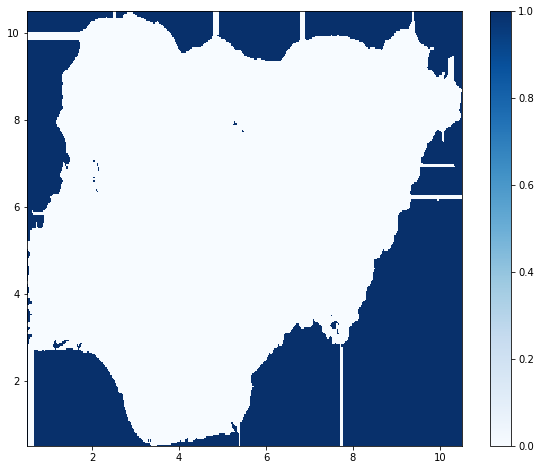

In [38]:
## Creating plot of malaria outbreak 

fig, ax = subplots(figsize=(10, 8))
plt.imshow(m_l, interpolation='nearest', cmap='Blues', extent=(0.5,10.5,0.5,10.5))
plt.colorbar()
plt.savefig('logit.png')

## Conditional Random Fields - A Discrimitive Approach

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt

import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics



In [93]:
classifier_X = classification_data[['Resistance', 'Fever_prop','Mosquito_prop','Temp_suitability', 'Proximity_to_urban', 'Urban', 'Annual_mean_temp', 'Cropland', 'Precipitation','Vegetation', 'Annual_temp_range', 'Water_bodies']]
classifier_Y = classification_data['Endemicity']

X_trainc, X_testc = train_test_split(classifier_X, test_size=0.2, random_state=21)
Y_trainc, Y_testc = train_test_split(classifier_Y, test_size=0.2, random_state=21)

xtrain = X_trainc.values.tolist()
ytrain = Y_trainc.values.tolist()
xtest = X_testc.values.tolist()
ytest = Y_testc.values.tolist()

xtrain = np.asarray(xtrain)
ytrain = np.asarray(ytrain)
xtest = np.asarray(xtest)
ytest = np.asarray(ytest)



In [94]:
crf = sklearn_crfsuite.CRF(algorithm = 'lbfgs', c1 = 0.1, c2 = 0.2, max_iterations = 100, all_possible_transitions = True)

In [96]:
crf.fit(xtrain, ytrain)

TypeError: 'numpy.float64' object is not iterable

In [97]:
y_pred_crf = crf.predict(xtest)

ValueError: Invalid model file '/var/folders/kl/h7x5_2yn5q14ld3_csqgqjp00000gn/T/model42k0115k.crfsuite'

In [ ]:
metrics.flat_f1_score(ytest, y_pred, average='weighted')

In [ ]:
from pystruct.models import ChainCRF
from pystruct.learners import FrankWolfeSSVM

In [ ]:
model = ChainCRF()
ssvm = FrankWolfeSSVM(model=model, C=.1, max_iter=10)
ssvm.fit(train, test) 
FrankWolfeSSVM(C=0.1, batch_mode=False, check_dual_every=10,
            do_averaging=True, line_search=True, logger=None, max_iter=10,
            model=ChainCRF())